In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import ipywidgets as widgets
from IPython.display import display
import glob
from datetime import datetime,timedelta
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

In [3]:
!pip install xgboost

In [4]:
locs = {'waiting_folder' : 'data/waiting times'}

In [5]:
#reading the data

In [6]:
waiting_times = list()
for attraction in tqdm(os.listdir(locs['waiting_folder'])):
    filename = os.path.join(locs['waiting_folder'], attraction)
    df = pd.read_csv(filename)
    if df.empty:
        continue
    df.insert(0, 'attraction', attraction.split('.')[0])
    waiting_times.append(df)

df_wait_raw = pd.concat(waiting_times, ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████████████| 52/52 [00:11<00:00,  4.49it/s]


In [141]:
#data cleaning

In [7]:
df_wait = df_wait_raw.copy()
# Cleaning the actual waiting times
# Removing outliers from actuals
df_wait = df_wait[((df_wait.SACTMIN >= -1000) & (df_wait.SACTMIN < 360)) | (df_wait.SACTMIN.isnull())]
# Removing outliers from posted (attraction closed at -999)
df_wait = df_wait[(df_wait.SPOSTMIN >= -998.99) | (df_wait.SPOSTMIN.isnull())]

df_wait['date'] = pd.to_datetime(df_wait.date, format = '%m/%d/%Y')
df_wait['datetime'] = pd.to_datetime(df_wait.datetime, format = '%Y-%m-%d %H:%M:%S')

print(f"Removed {len(df_wait_raw) - len(df_wait)} rows")

# You could split the dataset into two seperate dataframes (plusjes & minnetjes :-))
df_wait_act = df_wait[~df_wait.SACTMIN.isnull()].drop('SPOSTMIN', axis = 1)
df_wait_post = df_wait[~df_wait.SPOSTMIN.isnull()].drop('SACTMIN', axis = 1)

attractions = df_wait.attraction.unique()

Removed 1318703 rows


In [8]:
# Extract "minutes from df_wait" from the datetime column
df_wait_post['minute'] = df_wait_post['datetime'].dt.hour * 60 + df_wait_post['datetime'].dt.minute

In [9]:
df_wait_post['attraction'].unique()

array(['7_dwarfs_train', 'alien_saucers', 'astro_orbiter', 'barnstormer',
       'big_thunder_mtn', 'buzz_lightyear', 'carousel_of_progress',
       'country_bears', 'dinosaur', 'dumbo', 'enchanted_tiki_rm',
       'expedition_everest', 'flight_of_passage', 'hall_of_presidents',
       'haunted_mansion', 'it_s_a_small_world', 'jungle_cruise',
       'kilimanjaro_safaris', 'laugh_floor', 'liberty_sq_riverboat',
       'mad_tea_party', 'magic_carpets', 'navi_river', 'peoplemover',
       'peter_pan_s_flight', 'philharmagic', 'pirates_of_caribbean',
       'pirate_s_adventure', 'princess_hall__cinderella_elena',
       'princess_hall__rapunzel_tiana', 'regal_carrousel',
       'rock_n_rollercoaster', 'slinky_dog', 'soarin',
       'sorcerers_of_the_mk', 'spaceship_earth', 'space_mountain',
       'splash_mountain', 'swiss_family_tree', 'tom_land_speedway',
       'tom_sawyer_island', 'town_sq_mickey', 'toy_story_mania',
       'under_the_sea', 'winnie_the_pooh'], dtype=object)

In [10]:
#processing time shift only

In [ ]:
#interpolating and prepering  traing dataframe

In [11]:
groups_itp = list()

for (date, attraction), group in tqdm(df_wait.groupby(['date', 'attraction'])):
    # Time shift by 3 hours
    time_shifted = group['datetime'] - timedelta(hours=3)
    group['minute'] = 3 * 60 + time_shifted.dt.hour * 60 + time_shifted.dt.minute

    # Ensure the required columns exist before proceeding
    if not {'SACTMIN', 'SPOSTMIN'}.issubset(group.columns):
        print(f"Skipping {date} - {attraction}: Missing columns")
        continue  # Skip this iteration if columns are missing

    # Drop unnecessary columns and compute the mean for duplicate minutes
    group = group.drop(columns=['datetime', 'attraction', 'date'], errors='ignore')  # Avoid KeyError
    group = group.groupby('minute', as_index=False)[['SACTMIN', 'SPOSTMIN']].mean()

    # Define the new index (0 to 1620 minutes in 30-minute intervals)
    new_index = np.arange(0, 27 * 60 + 1, 30)

    # Set 'minute' as the index and reindex with interpolation
    group = group.set_index('minute')
    reindexed = group.reindex(np.unique(np.concatenate([new_index, group.index]))).interpolate(method='linear')

    # Keep only the required time indices
    resampled = reindexed.loc[new_index].reset_index()

    # Round to nearest 5-minute interval
    for col in ['SACTMIN', 'SPOSTMIN']:
        if col in resampled.columns:
            resampled[col] = ((resampled[col] + 2.5) // 5) * 5
    
    # Interpolate SPOSTMIN to fill blanks
    resampled['SPOSTMIN_interp'] = resampled['SPOSTMIN'].interpolate(method='linear')

    # Calculate the actual over posted ratio
    resampled['actual_over_posted'] =  resampled['SACTMIN'] / resampled['SPOSTMIN_interp']

    # Insert date and attraction columns
    resampled.insert(0, 'date', date)
    resampled.insert(1, 'attraction', attraction)

    # Append to final list
    groups_itp.append(resampled)

100%|████████████████████████████████████████████████████████████████████████████| 77543/77543 [05:41<00:00, 227.37it/s]


In [12]:
df_netjes_itp = pd.concat(groups_itp, ignore_index=True)

In [13]:
df_netjes_itp.sample(20)

,date,attraction,minute,SACTMIN,SPOSTMIN,SPOSTMIN_interp,actual_over_posted
1878729,2018-01-16,soarin,1170,30.0,25.0,25.0,1.200000
3062601,2019-09-08,barnstormer,1080,5.0,5.0,5.0,1.000000
70644,2015-02-13,regal_carrousel,720,5.0,5.0,5.0,1.000000
877039,2016-06-18,spaceship_earth,270,NaN,NaN,NaN,NaN
977263,2016-08-19,peoplemover,690,NaN,NaN,NaN,NaN
2879562,2019-06-08,peoplemover,1110,10.0,25.0,25.0,0.400000
3041731,2019-08-28,flight_of_passage,330,NaN,NaN,NaN,NaN
377243,2015-08-19,jungle_cruise,1590,NaN,5.0,5.0,NaN
1273411,2017-02-16,philharmagic,1530,10.0,5.0,5.0,2.000000
3057810,2019-09-05,pirates_of_caribbean,900,NaN,10.0,10.0,NaN


/tmp/ipykernel_91869/486937282.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=problematic_counts.index,y=problematic_counts.values,palette = 'coolwarm')


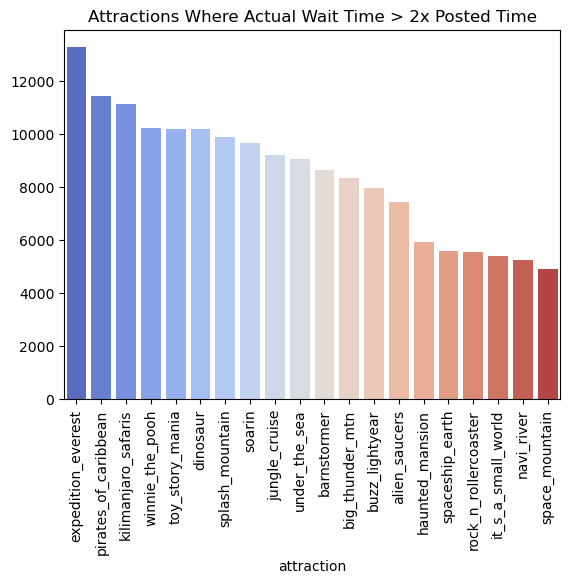

In [79]:
# Get attractions where actual time is more than double the posted time
problematic = df_netjes_itp[df_netjes_itp['actual_over_posted'] > 2]
problematic_counts = problematic['attraction'].value_counts().sort_values(ascending=False).head(20)
sns.barplot(x=problematic_counts.index,y=problematic_counts.values,palette = 'coolwarm')
plt.xticks(rotation =90)
plt.title('Attractions Where Actual Wait Time > 2x Posted Time')
plt.show()

it means guests are getting frustrated — they think they’ll wait 30 minutes, but it ends up being an hour or more.
to do:
improving wait time accuracy
Maybe look into staffing, ride reliability, or tracking systems there

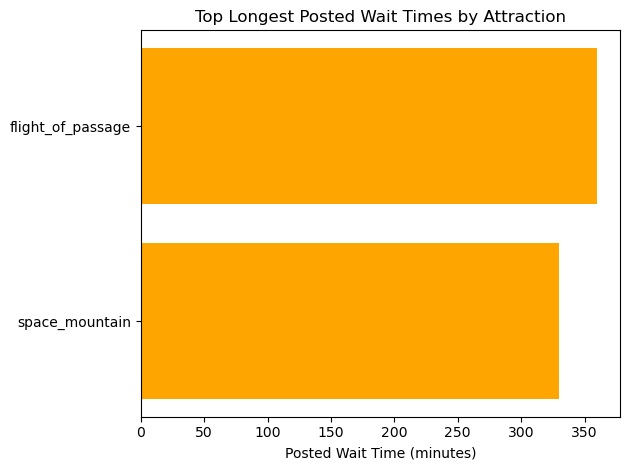

In [81]:
# Get attractions with the longest absolute wait times (using SPOSTMIN_interp)
long_waits = df_netjes_itp.sort_values('SPOSTMIN_interp', ascending=False).head()

plt.barh(long_waits['attraction'], long_waits['SPOSTMIN_interp'], color='orange')
plt.xlabel('Posted Wait Time (minutes)')
plt.title('Top Longest Posted Wait Times by Attraction')
plt.gca().invert_yaxis()  # Highest wait at top
plt.tight_layout()
plt.show()

In [ ]:
flight_of_passage) had the longest wait time — almost 360 minutes! That’s like waiting for 6 hours! 
The second one (space_mountain) also had a long wait — about 330 minutes (over 5 hours).

/tmp/ipykernel_91869/1346878346.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=common_df, x='attraction', y='frequency', palette='viridis')


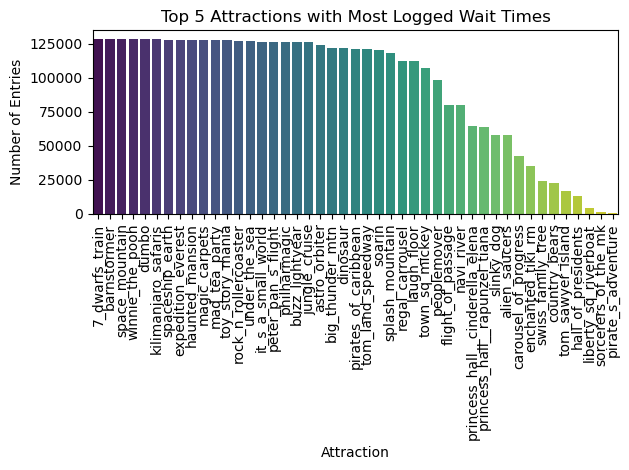

In [84]:
# Find attractions that have consistently long waits (appearing multiple times)
attraction_frequency = df_netjes_itp.groupby('attraction').size().sort_values(ascending=False)
common_long_waits = attraction_frequency
common_df = common_long_waits.reset_index()
common_df.columns = ['attraction','frequency']

sns.barplot(data=common_df, x='attraction', y='frequency', palette='viridis')

plt.title('Top 5 Attractions with Most Logged Wait Times')
plt.xlabel('Attraction')
plt.ylabel('Number of Entries')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
They’re popular
They have complex operational dynamics
Or the data collection is biased toward them

In [14]:
# Save the full cleaned and interpolated dataset to csv
df_netjes_itp.to_csv("data/clean/waiting_times_interpolated.csv")

In [15]:
# Select the dataset for training our prediction model and save it to csv
# Drop unnecessary columns and rows without actual_over_posted ratio
training_dataset = df_netjes_itp.drop(columns=['SPOSTMIN', 'SPOSTMIN_interp']).dropna(subset=['actual_over_posted'])

training_dataset.to_csv("data/clean/training_dataset.csv", index=False)

In [ ]:
#dropping the missing values

In [16]:
training_dataset.head()

,date,attraction,minute,SACTMIN,actual_over_posted
17,2015-01-01,7_dwarfs_train,510,55.0,0.733333
18,2015-01-01,7_dwarfs_train,540,55.0,0.523810
19,2015-01-01,7_dwarfs_train,570,55.0,0.458333
20,2015-01-01,7_dwarfs_train,600,55.0,0.647059
21,2015-01-01,7_dwarfs_train,630,55.0,0.611111


In [ ]:
training_dataset.shape

In [17]:
training_dataset['date'] = pd.to_datetime(training_dataset['date'])
training_dataset['date'].dtype

dtype('<M8[ns]')

In [85]:
df_time = pd.read_csv('data/overview data/metadata.csv')
df_time.shape

(2079, 181)

In [86]:
df_time.columns.str.strip().str.upper()

Index(['DATE', 'WDW_TICKET_SEASON', 'DAYOFWEEK', 'DAYOFYEAR', 'WEEKOFYEAR',
       'MONTHOFYEAR', 'YEAR', 'SEASON', 'HOLIDAYPX', 'HOLIDAYM',
       ...
       'HSFIREWKS', 'AKPRDDAY', 'AKPRDDT1', 'AKPRDDT2', 'AKPRDDN', 'AKFIREN',
       'AKSHWNGT', 'AKSHWNT1', 'AKSHWNT2', 'AKSHWNN'],
      dtype='object', length=181)

In [87]:
df_time =df_time[
    ['DATE', 'DAYOFWEEK', 'DAYOFYEAR', 'WEEKOFYEAR', 'MONTHOFYEAR', 'YEAR',
       'SEASON']
]

'HOLIDAY', 'HOLIDAYM', 'HOLIDAYPX', 'WDW_TICKET_SEASON',
       'WEATHER_WDWHIGH', 'WEATHER_WDWLOW', 'WEATHER_WDWPRECIP', 'MKFIREN',
       'EPFIREN', 'HSFIREN', 'AKFIREN', 'MKPRDDAY', 'HSFIREWKS', 'AKSHWNGT',
       'MKHOURS', 'EPHOURS', 'HSHOURS', 'AKHOURS'

In [89]:
df_time 
df_time.shape

(2079, 7)

In [90]:
df_time['DATE'] = pd.to_datetime(df_time['DATE'])


In [91]:
df_time['DATE'].dtype


dtype('<M8[ns]')

In [92]:
df_time = df_time.rename(columns={'DATE' : 'date'})

In [93]:
df_time = df_time[df_time['YEAR'] != 2020]

In [94]:
#joining the dataset
df_merged = training_dataset.merge(df_time,on ='date',how ='left')

In [95]:
df_merged.head()

,date,attraction,minute,SACTMIN,actual_over_posted,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,SEASON
0,2015-01-01,7_dwarfs_train,510,55.0,0.733333,5.0,0.0,0.0,1.0,2015.0,CHRISTMAS PEAK
1,2015-01-01,7_dwarfs_train,540,55.0,0.523810,5.0,0.0,0.0,1.0,2015.0,CHRISTMAS PEAK
2,2015-01-01,7_dwarfs_train,570,55.0,0.458333,5.0,0.0,0.0,1.0,2015.0,CHRISTMAS PEAK
3,2015-01-01,7_dwarfs_train,600,55.0,0.647059,5.0,0.0,0.0,1.0,2015.0,CHRISTMAS PEAK
4,2015-01-01,7_dwarfs_train,630,55.0,0.611111,5.0,0.0,0.0,1.0,2015.0,CHRISTMAS PEAK


In [96]:
df_merged['hour'] = (df_merged['minute'] // 60).astype(int)

In [97]:
df_merged['time_of_day'] = pd.cut(df_merged['hour'], 
                                   bins=[-1, 10, 14, 18, 24], #-1 to 10 morning,10-14 midday,14-18 afternoon,18-24 evening. -1 is used to make sure that midnight is included
                                   labels=['Morning', 'Midday', 'Afternoon', 'Evening'])

In [98]:
df_merged.columns.to_list()

['date',
 'attraction',
 'minute',
 'SACTMIN',
 'actual_over_posted',
 'DAYOFWEEK',
 'DAYOFYEAR',
 'WEEKOFYEAR',
 'MONTHOFYEAR',
 'YEAR',
 'SEASON',
 'hour',
 'time_of_day']

In [99]:
time_summary = df_merged.groupby('time_of_day')[['SACTMIN', 'actual_over_posted']].mean().reset_index()


/tmp/ipykernel_91869/3663032166.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_summary = df_merged.groupby('time_of_day')[['SACTMIN', 'actual_over_posted']].mean().reset_index()


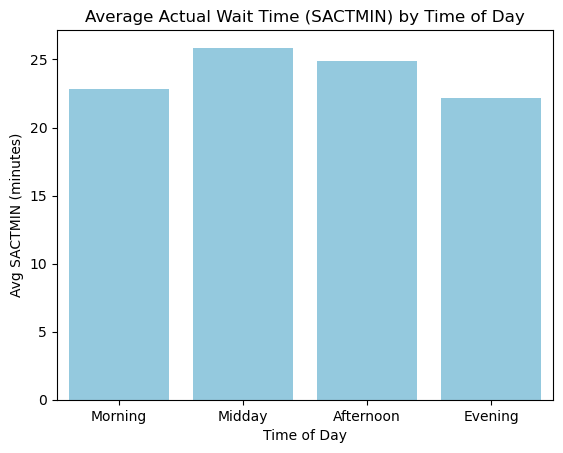

In [100]:
sns.barplot(data=time_summary, x='time_of_day', y='SACTMIN', color='skyblue')
plt.title('Average Actual Wait Time (SACTMIN) by Time of Day')
plt.ylabel('Avg SACTMIN (minutes)')
plt.xlabel('Time of Day')
plt.show()

midday and afternoon generally have longer waiting period

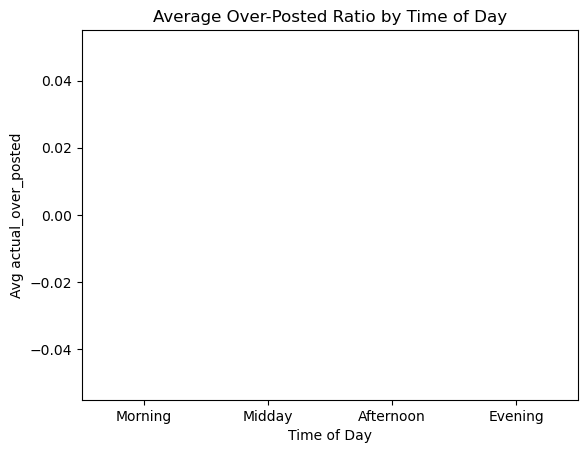

In [101]:
sns.barplot(data=time_summary, x='time_of_day', y='actual_over_posted', color='salmon')
plt.title('Average Over-Posted Ratio by Time of Day')
plt.ylabel('Avg actual_over_posted')
plt.xlabel('Time of Day')
plt.show()

In [102]:
df_merged['actual_over_posted'].describe()

count    1.751616e+06
mean              inf
std               NaN
min      0.000000e+00
25%      4.444444e-01
50%      7.500000e-01
75%      1.250000e+00
max               inf
Name: actual_over_posted, dtype: float64

In [103]:
# most values in actual_overposted are infinite meaning spostmin_interp ==0 then dividing by 0 leads to infinite
# to replace infinite values with NAN
df_merged['actual_over_posted'] = df_merged['actual_over_posted'].replace([np.inf, -np.inf],np.nan)

In [104]:
df_merged['actual_over_posted'].describe()

count    1.745095e+06
mean     1.153500e+00
std      1.436684e+00
min      0.000000e+00
25%      4.375000e-01
50%      7.500000e-01
75%      1.200000e+00
max      2.600000e+01
Name: actual_over_posted, dtype: float64

/tmp/ipykernel_91869/2844378742.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_summary = df_merged.groupby('time_of_day')[['SACTMIN', 'actual_over_posted']].mean().reset_index()


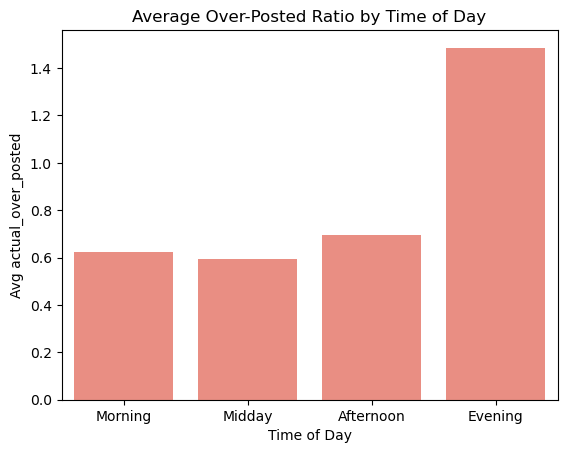

In [105]:
time_summary = df_merged.groupby('time_of_day')[['SACTMIN', 'actual_over_posted']].mean().reset_index()
sns.barplot(data=time_summary, x='time_of_day', y='actual_over_posted', color='salmon')
plt.title('Average Over-Posted Ratio by Time of Day')
plt.ylabel('Avg actual_over_posted')
plt.xlabel('Time of Day')
plt.show()

observation people wait longer in the evening. this means the evenings are either under sourced, under prepared for or overcrowded.
recommendation:
improve work flow in the evening,increase staff,staggered tickets etc.

# Feature impact Analysis

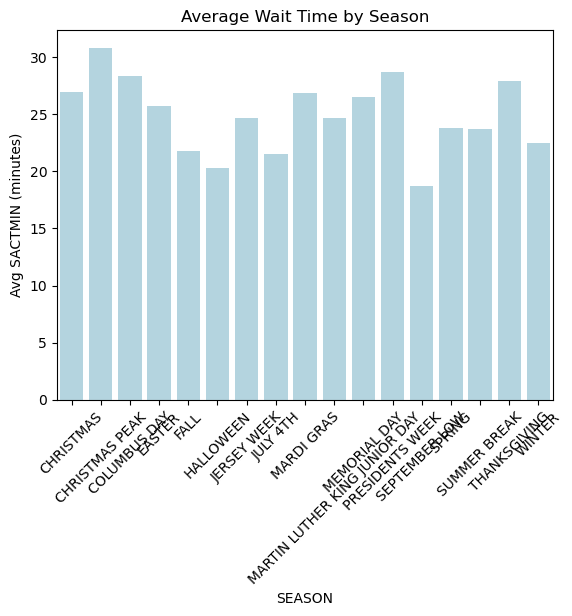

In [106]:
season_summary = df_merged.groupby('SEASON')[['SACTMIN', 'actual_over_posted']].mean().reset_index()

sns.barplot(data=season_summary, x='SEASON', y='SACTMIN', color='lightblue')
plt.title('Average Wait Time by Season')
plt.ylabel('Avg SACTMIN (minutes)')
plt.xticks(rotation=45)
plt.show()


Christmas Peak has the highest average wait time, followed by memorial day and Summer Break.

In [67]:
holiday_summary = df_merged.groupby('HOLIDAY')[['SACTMIN', 'actual_over_posted']].mean().reset_index()

sns.barplot(data=holiday_summary, x='HOLIDAY', y='SACTMIN', color='lightgreen')
plt.title('Average Wait Time on Holidays')
plt.ylabel('Avg SACTMIN (minutes)')
plt.show()


KeyError: 'HOLIDAY'

In [107]:
ticket_summary = df_merged.groupby('WDW_TICKET_SEASON')[['SACTMIN', 'actual_over_posted']].mean().reset_index()

sns.barplot(data=ticket_summary, x='WDW_TICKET_SEASON', y='SACTMIN', color='orange')
plt.title('Average Wait Time by Ticket Season')
plt.ylabel('Avg SACTMIN (minutes)')
plt.xticks(rotation=45)
plt.show()


KeyError: 'WDW_TICKET_SEASON'

These show that seasonality, holidays, and ticket pricing clearly affect actual wait times.

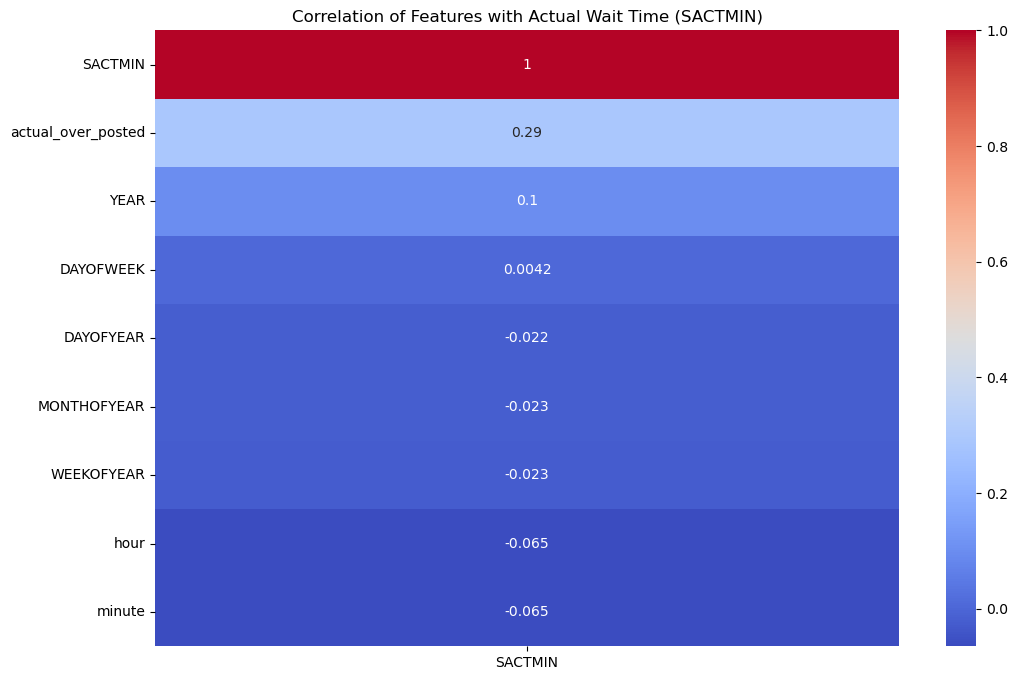

In [108]:
numeric_cols = df_merged.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 8))
sns.heatmap(df_merged[numeric_cols].corr()[['SACTMIN']].sort_values('SACTMIN', ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlation of Features with Actual Wait Time (SACTMIN)")
plt.show()


observation
actual _over posted has moderate correlation 0.29 -  Makes sense, because longer waits often cause bigger posting errors.
AKSHWNGT 0.16 - Attraction-specific event — could be a show or parade. These events likely drive crowds, increasing waits.
AKHOURS  0.11 - Longer operating hours at Animal Kingdom could correlate with busy days or longer wait times.
YEAR 0.10 - Possibly due to growth in park visitors over time or operational changes.

WEATHER_WDWLOW (−0.079)
minute, hour, DAYOFWEEK, WEEKOFYEAR, etc.
 have very little to no relationship with wait times on their own. That doesn't mean they're useless — they might still matter in combinations 

In [109]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor,plot_importance
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [110]:
#encoding categorical features
df_merged.describe(include=('object','bool'))


,attraction,SEASON
count,1751616,1274327
unique,42,17
top,haunted_mansion,SPRING
freq,72456,343487


In [111]:
df_merged.shape

(1751616, 13)

In [112]:
#Select only important features from the merged dataset
important_features = ['actual_over_posted','YEAR','DAYOFWEEK','DAYOFYEAR','MONTHOFYEAR','WEEKOFYEAR','hour','minute']
    

In [113]:
#Drop rows with missing values in selected colomns
df_filtered = df_merged.dropna(subset=important_features)

In [114]:
X = df_filtered.drop('SACTMIN',axis=1)
y = df_filtered['SACTMIN']

In [115]:
X =X.drop(columns=['date'])
categorical_cols = X.select_dtypes(include=['object','category']).columns
X = pd.get_dummies(X,columns=categorical_cols,drop_first=True)

In [116]:
#X = X.drop(columns=['AKFIREN'])

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [118]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1101373, 68)
(275344, 68)
(1101373,)
(275344,)


In [119]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1376717 entries, 0 to 1633931
Data columns (total 68 columns):
 #   Column                                      Non-Null Count    Dtype  
---  ------                                      --------------    -----  
 0   minute                                      1376717 non-null  int64  
 1   actual_over_posted                          1376717 non-null  float64
 2   DAYOFWEEK                                   1376717 non-null  float64
 3   DAYOFYEAR                                   1376717 non-null  float64
 4   WEEKOFYEAR                                  1376717 non-null  float64
 5   MONTHOFYEAR                                 1376717 non-null  float64
 6   YEAR                                        1376717 non-null  float64
 7   hour                                        1376717 non-null  int64  
 8   attraction_alien_saucers                    1376717 non-null  bool   
 9   attraction_astro_orbiter                    1376717 non-null  

In [120]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42,tree_method='hist',verbosity=1)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [121]:
y_pred = model.predict(X_test)

In [122]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


In [123]:
print(f" Model Evaluation:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR² Score: {r2:.2f}")


 Model Evaluation:
MAE: 7.47
RMSE: 11.83
R² Score: 0.70


<Figure size 1000x600 with 0 Axes>

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


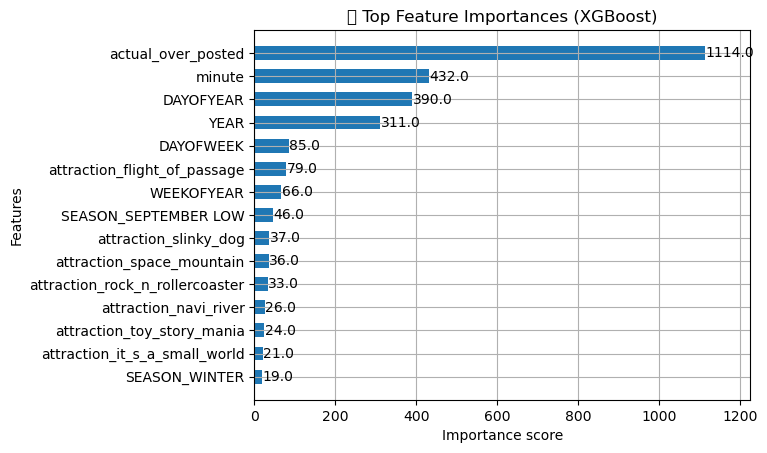

In [124]:
plt.figure(figsize=(10, 6))
plot_importance(model, height=0.6, max_num_features=15)
plt.title('🔍 Top Feature Importances (XGBoost)')
plt.show()

In [55]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from scipy.stats import zscore

In [125]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)



In [126]:
# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}


In [127]:

# Initialize base model
xgb_model = XGBRegressor(tree_method='hist', random_state=101)



In [128]:
# GridSearchCV with 5-fold cross-validation
grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                    scoring='neg_mean_squared_error', cv=5, verbose=1)



In [129]:
# Fit the model
grid.fit(X_train, y_train)



Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [50, 100], 'subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [130]:
# Best model
best_model = grid.best_estimator_



In [131]:
# Evaluate on test set
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)



In [133]:
print(f"Best Parameters: {grid.best_params_}")
print(f" RMSE on Test Set: {rmse:.2f}")
print(f" R² Score: {r2:.2f}")


Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
 RMSE on Test Set: 11.82
 R² Score: 0.71


In [ ]:
MAE = 7.51
Good! A 7-minute average error is reasonable in the context of theme park wait times.

Shows the model is fairly accurate at a basic level.

📉 RMSE = 11.91
RMSE penalizes bigger errors more than MAE.

Tells us there are some larger outliers, but nothing extremely wild.

💪 R² = 0.71
This is strong!

Your model is explaining 70% of the patterns in actual wait times.

That means it has learned meaningful relationships from the input features.

In [ ]:
best

In [81]:
# Create a rule-based optimized posted time
df_merged['optimized_postmin'] = df_merged['SACTMIN'] * 1.1
df_merged['optimized_postmin'] = (df_merged['optimized_postmin'] / 5).apply(np.ceil) * 5
df_merged['optimized_postmin'] = df_merged[['optimized_postmin', 'SACTMIN']].max(axis=1)

# Compare effectiveness
df_merged['original_gap'] = df_merged['SPOSTMIN'] - df_merged['SACTMIN']
df_merged['optimized_gap'] = df_merged['optimized_postmin'] - df_merged['SACTMIN']


KeyError: 'SACTMIN'

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(df_merged['original_gap'], color='red', label='Original', kde=True)
sns.histplot(df_merged['optimized_gap'], color='green', label='Optimized', kde=True)
plt.title("Gap Between SACTMIN and Posted Times")
plt.xlabel("Gap (minutes)")
plt.legend()
plt.show()


In [43]:
X = training_dataset.drop('actual_over_posted',axis=1)
y= training_dataset['actual_over_posted']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Train XGBoost model
model = XGBRegressor(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Predict
predictions = model.predict(X_test)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:date: datetime64[ns], attraction: object

In [ ]:
from

In [23]:
df_clean = df_netjes_itp.dropna(subset=['SACTMIN', 'SPOSTMIN'])

In [24]:
df_clean.shape

(1752624, 7)

In [25]:
print(df_clean.shape)
print(df_netjes_itp.shape)

(1752624, 7)
(4264865, 7)


In [26]:
df_clean['over_posted'] = df_clean['SPOSTMIN'] - df_clean['SACTMIN']

/tmp/ipykernel_132/2031088181.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['over_posted'] = df_clean['SPOSTMIN'] - df_clean['SACTMIN']


In [27]:
df_clean['over_posted'].describe()

count    1.752624e+06
mean     8.480992e+00
std      2.471494e+01
min     -2.150000e+02
25%     -5.000000e+00
50%      5.000000e+00
75%      2.000000e+01
max      2.800000e+02
Name: over_posted, dtype: float64

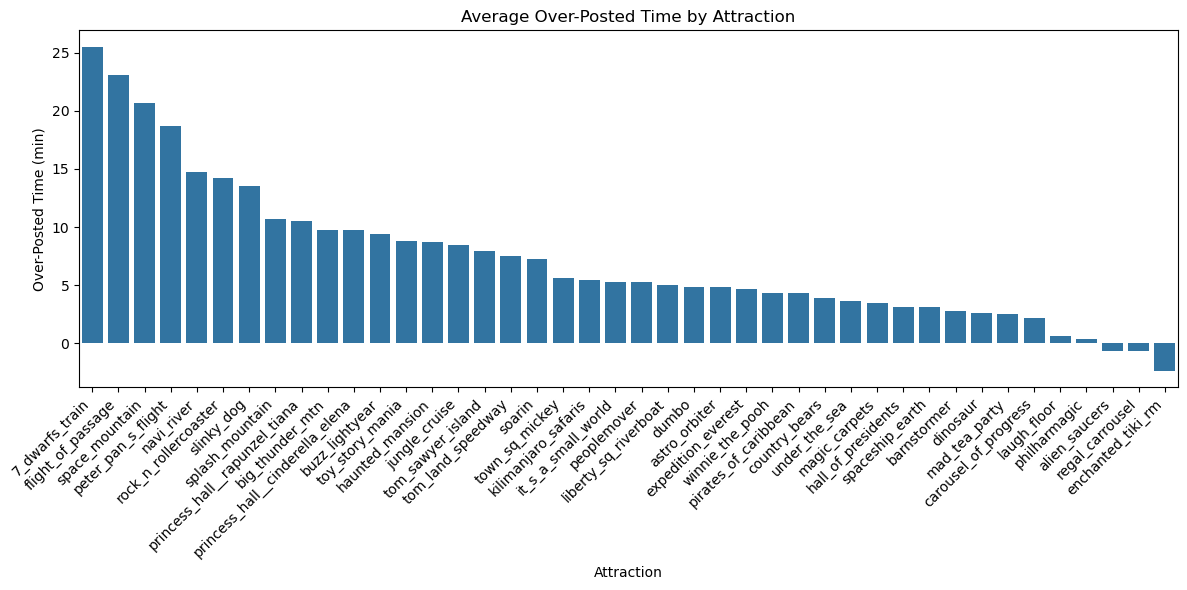

In [33]:
# Step 1: Get over-posted average per attraction (as a DataFrame)
df_cleaned_overpost = df_clean.groupby('attraction')['over_posted'].mean().sort_values(ascending=False).reset_index()

# Step 2: Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_cleaned_overpost, x='attraction', y='over_posted')
plt.xticks(rotation=45, ha='right')
plt.title("Average Over-Posted Time by Attraction")
plt.ylabel("Over-Posted Time (min)")
plt.xlabel("Attraction")
plt.show()


In [34]:
df_cleaned_overpost.head(5)

,attraction,over_posted
0,7_dwarfs_train,25.528348
1,flight_of_passage,23.120235
2,space_mountain,20.657565
3,peter_pan_s_flight,18.682016
4,navi_river,14.773368


In [2]:
#defining the file paths
path_waiting_times =os.path.join('..', 'data', 'waiting times')

In [3]:
print("Working directory:", os.getcwd())


Working directory: /home/jovyan/work


In [4]:
#reading files in the waiting time directory
dfs = []
for filename in glob.glob(os.path.join(path_waiting_times,'*.csv')):
    df = pd.read_csv(filename)
    if df.empty:
        print(f"skipping empty files:{filename}")
        continue
    
    #to extract just the file name without the path
    attraction_name = os.path.basename(filename).replace('.csv','')
    df['attractions'] = attraction_name
    dfs.append(df)

df_waiting_time_data = pd.concat(dfs,ignore_index = True)
df_waiting_time = df_waiting_time_data.copy()
df_waiting_time.head()

ValueError: No objects to concatenate

Step 2 Data Cleaning

In [ ]:
Preprocessing step
Add minute of day.
Split dataframe into actual and posted waiting time.
Remove all -999 as these are waiting times at times that the attraction is closed.


In [30]:
df_waiting_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10306140 entries, 0 to 10306139
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   datetime     object 
 2   SACTMIN      float64
 3   SPOSTMIN     float64
 4   attractions  object 
dtypes: float64(2), object(3)
memory usage: 393.1+ MB


In [31]:
df_waiting_time.isnull().mean()

date           0.000000
datetime       0.000000
SACTMIN        0.981333
SPOSTMIN       0.018667
attractions    0.000000
dtype: float64

In [32]:
  #filling null value with mean value
df_waiting_time['SACTMIN'] = df_waiting_time['SACTMIN'].fillna(df_waiting_time['SACTMIN'].mean())
df_waiting_time['SPOSTMIN'] = df_waiting_time['SPOSTMIN'].fillna(df_waiting_time['SPOSTMIN'].mean())


In [33]:
df_waiting_time.isnull().sum()

date           0
datetime       0
SACTMIN        0
SPOSTMIN       0
attractions    0
dtype: int64

In [34]:
# handeling outliers
df_waiting_time.describe(include ='all')

,date,datetime,SACTMIN,SPOSTMIN,attractions
count,10306140,10306140,1.030614e+07,1.030614e+07,10306140
unique,2335,1782632,NaN,NaN,45
top,11/08/2021,2021-11-05 14:00:01,NaN,NaN,space_mountain
freq,13142,43,NaN,NaN,321959
mean,NaN,NaN,2.484715e+01,-9.962901e+01,NaN
std,NaN,NaN,1.710331e+02,3.461101e+02,NaN
min,NaN,NaN,-9.291800e+04,-9.990000e+02,NaN
25%,NaN,NaN,2.484715e+01,1.000000e+01,NaN
50%,NaN,NaN,2.484715e+01,2.000000e+01,NaN
75%,NaN,NaN,2.484715e+01,4.500000e+01,NaN


In [35]:
#detecting outliers from SACTMIN and SPOSTMIN
df = df_waiting_time.copy()
def outlier_detection(df,column):
    Q1 = df[column].quantile(0.25)
    Q3 =df[column].quantile(0.75)
    
    IQR = Q3 - Q1
    lower_bound = Q1 -1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound )|( df[column] > upper_bound)]

outlier_SACTMIN = outlier_detection(df,'SACTMIN')
outlier_SPOSTMIN =outlier_detection(df,'SPOSTMIN')

print(outlier_SACTMIN)
print(outlier_SPOSTMIN)

                date             datetime  SACTMIN   SPOSTMIN      attractions
2         01/01/2015  2015-01-01 08:05:30     54.0 -99.629006   7_dwarfs_train
5         01/01/2015  2015-01-01 08:22:16     55.0 -99.629006   7_dwarfs_train
177       01/02/2015  2015-01-02 12:20:00    160.0 -99.629006   7_dwarfs_train
264       01/02/2015  2015-01-02 21:49:47     65.0 -99.629006   7_dwarfs_train
281       01/02/2015  2015-01-03 00:44:09     19.0 -99.629006   7_dwarfs_train
...              ...                  ...      ...        ...              ...
10305771  12/26/2021  2021-12-26 17:28:07     51.0 -99.629006  winnie_the_pooh
10305824  12/26/2021  2021-12-26 22:46:18      1.0 -99.629006  winnie_the_pooh
10305950  12/27/2021  2021-12-27 19:24:28     14.0 -99.629006  winnie_the_pooh
10305996  12/28/2021  2021-12-28 08:50:05     16.0 -99.629006  winnie_the_pooh
10306045  12/28/2021  2021-12-28 13:38:27     15.0 -99.629006  winnie_the_pooh

[192389 rows x 5 columns]
                date     

In [36]:
df.sample(2)

,date,datetime,SACTMIN,SPOSTMIN,attractions
8060375,08/30/2015,2015-08-30 20:00:28,24.847148,15.0,space_mountain
7607387,03/25/2019,2019-03-25 21:36:06,24.847148,-999.0,soarin


In [37]:
# to remove the outlier
def remove_outlier(df,column):
    Q1 = df[column].quantile(0.25)
    Q3 =df[column].quantile(0.75)
    
    IQR = Q3 - Q1
    lower_bound = Q1 -1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound ) & ( df[column] <= upper_bound)]

df_cleaned = remove_outlier(df,'SACTMIN')
df_cleaned =remove_outlier(df_cleaned,'SPOSTMIN')


In [38]:
df_cleaned.sample()

,date,datetime,SACTMIN,SPOSTMIN,attractions
1032236,09/25/2021,2021-09-25 16:45:01,24.847148,10.0,barnstormer


In [39]:
#date validation
df_cleaned['datetime'] = pd.to_datetime(df_cleaned['datetime'], format = '%Y-%m-%d %H:%M:%S')
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'], format='%m/%d/%Y')


In [40]:
print(len(df_waiting_time))
print(len(df_cleaned))
print(len(df_waiting_time) - len(df_cleaned))


10306140
8428966
1877174


In [40]:
#splitting the dataframe in to actual and post

In [41]:
#splitting the dataframe in to actual and post    
df_cleaned_act = df_cleaned[~df_cleaned['SACTMIN'].isnull()].drop('SPOSTMIN',axis =1)
df_cleaned_post = df_cleaned[~df_cleaned['SPOSTMIN'].isnull()].drop('SACTMIN',axis =1)


In [42]:
df_cleaned.sample()

,date,datetime,SACTMIN,SPOSTMIN,attractions
3513794,2018-02-19,2018-02-19 19:07:07,24.847148,35.0,it_s_a_small_world


In [43]:
df_cleaned['attractions'].unique()

array(['7_dwarfs_train', 'alien_saucers', 'astro_orbiter', 'barnstormer',
       'big_thunder_mtn', 'buzz_lightyear', 'carousel_of_progress',
       'country_bears', 'dinosaur', 'dumbo', 'enchanted_tiki_rm',
       'expedition_everest', 'flight_of_passage', 'hall_of_presidents',
       'haunted_mansion', 'it_s_a_small_world', 'jungle_cruise',
       'kilimanjaro_safaris', 'laugh_floor', 'liberty_sq_riverboat',
       'mad_tea_party', 'magic_carpets', 'navi_river', 'peoplemover',
       'peter_pan_s_flight', 'philharmagic', 'pirates_of_caribbean',
       'pirate_s_adventure', 'princess_hall__cinderella_elena',
       'princess_hall__rapunzel_tiana', 'regal_carrousel',
       'rock_n_rollercoaster', 'slinky_dog', 'soarin',
       'sorcerers_of_the_mk', 'spaceship_earth', 'space_mountain',
       'splash_mountain', 'swiss_family_tree', 'tom_land_speedway',
       'tom_sawyer_island', 'town_sq_mickey', 'toy_story_mania',
       'under_the_sea', 'winnie_the_pooh'], dtype=object)

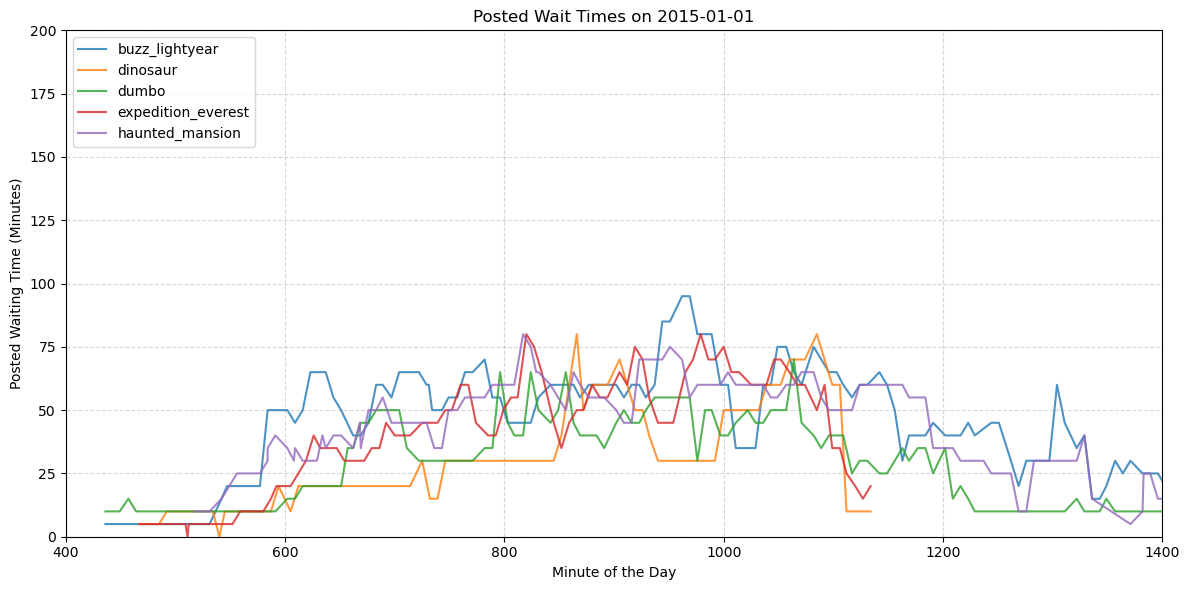

In [61]:

def plot_wait_times(input_date, attractions):
    global df_cleaned 
    # Convert input_date to datetime if it's a string
    if isinstance(input_date, str):
        date = pd.to_datetime(input_date).date()
    else:
        date = input_date
    
    # Filter data for the given date and attractions
    mask = (pd.to_datetime(df_cleaned['datetime']).dt.date == date) & (df_cleaned['attractions'].isin(attractions))
    df_filtered = df_cleaned[mask].copy()

    # Check if data exists for the given date & attractions
    if df_filtered.empty:
        print(f"No data available for {attractions} on {date}.")
        return None  # Stop execution if no data is available

    # Convert datetime to minutes since park opening
    df_filtered['minute'] = ((df_filtered['datetime'] - timedelta(hours=3)).dt.hour * 60 + 180 + df_filtered['datetime'].dt.minute)

    
    # Plot wait times for each attraction
    for attraction in attractions:
        attraction_data = df_filtered[df_filtered['attractions'] == attraction]

        # Ensure attraction has data before plotting
        if attraction_data.empty:
            print('skipping empty data')
            continue  # Skip this attraction if no data
        
        plt.figure(figsize=(12, 6))
        plt.plot(attraction_data['minute'],attraction_data['SPOSTMIN'],label=attraction,alpha=0.8)

    plt.title(f'Posted Wait Times on {date}')
    plt.xlabel('Minute of the Day')
    plt.ylabel('Posted Waiting Time (Minutes)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='upper left')
    plt.xticks() 
    plt.xlim(400, 1400)  
    plt.ylim(0, 200)  
    plt.tight_layout()

    return plt.gcf() 

# Example usage
sample_date = '2015-01-01'
sample_attractions = ['buzz_lightyear', 'dinosaur', 'dumbo', 'expedition_everest', 'haunted_mansion']

# Create the plot
plot_wait_times(sample_date, sample_attractions)
plt.show()


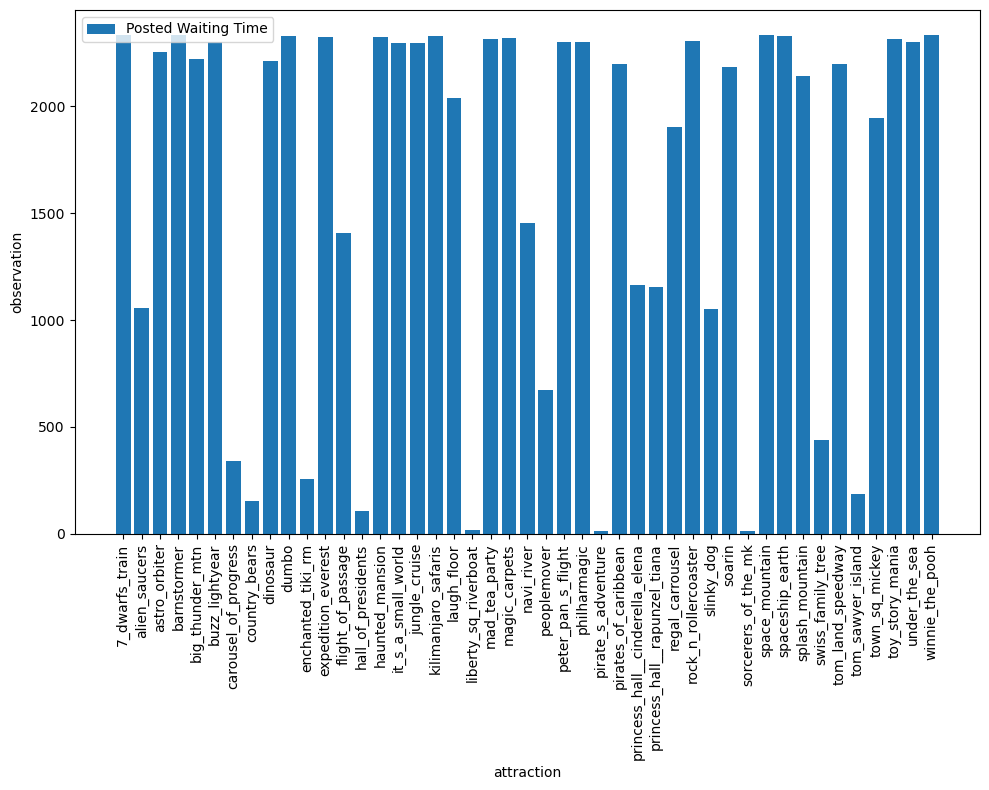

In [78]:
fig, ax = plt.subplots(figsize = (10,8))

posted_time = (df_cleaned_post.groupby(['date', 'attractions']).size().reset_index(name='observation')
        .groupby('attractions')['observation'].size())

ax.bar(posted_time.index,posted_time.values,label= 'Posted Waiting Time') 
ax.set_xlabel('attraction')
ax.set_ylabel('observation')
ax.tick_params(axis ='x',rotation=90)
ax.legend()
plt.tight_layout()
plt.show()                                       

In [ ]:
step 4: Study the distribution of data availability for actual waiting time information.
There seems to be not that much information on the actual waiting times at attractions. Is this because you
simply have limited data each day, or are there some days with a lot of information? Can you make some
visualizations to look into this?

<Axes: ylabel='Frequency'>

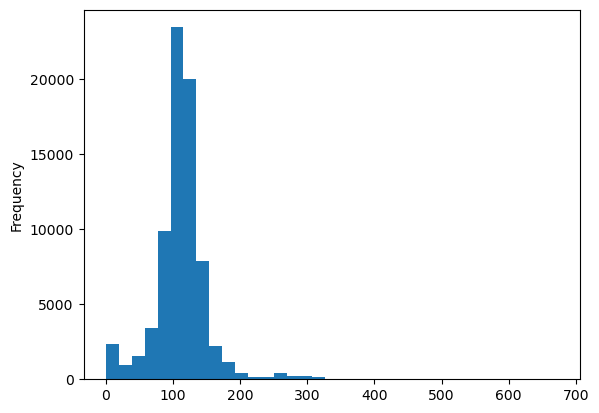

In [88]:
df_observations = (df_cleaned_act.groupby(['date', 'attractions'])
                                 .size()
                                 .reset_index(name='observations')
                                 [['observations', 'attractions', 'date']])




(df_observations['observations'].plot
                                .hist(bins = 35))

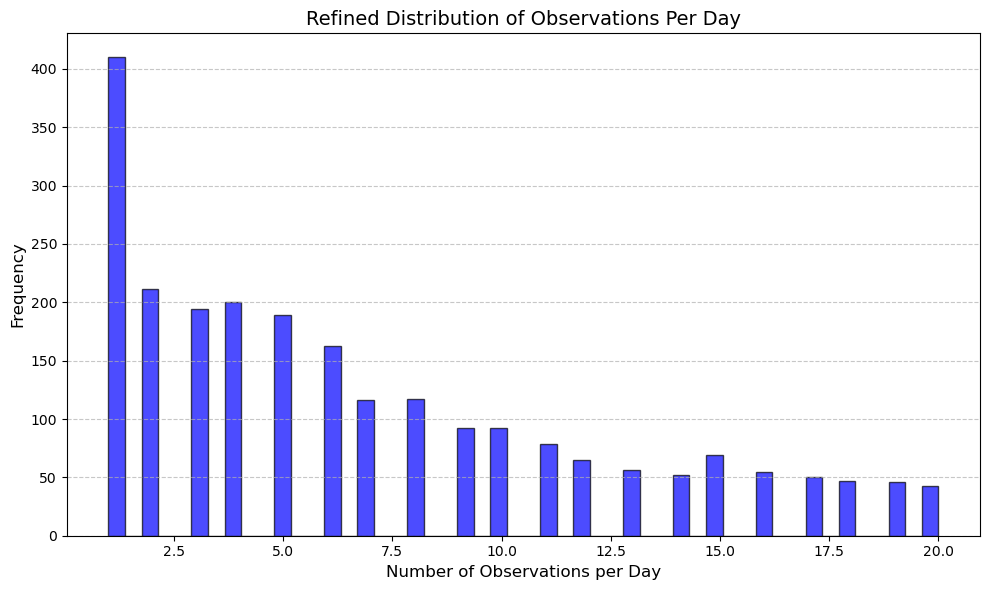

In [91]:


# **Step 1: Count Observations per Day per Attraction**
df_observations = (
    df_cleaned_act.groupby(['date', 'attractions'])  
    .size()
    .reset_index(name='observations')  
)

# **Step 2: Filter out large outliers (keep values <= 20)**
df_filtered = df_observations[df_observations['observations'] <= 20]

# **Step 3: Create Histogram**
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df_filtered['observations'], bins=50, color='blue', edgecolor='black', alpha=0.7)

# **Step 4: Customize Labels**
ax.set_xlabel('Number of Observations per Day', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Refined Distribution of Observations Per Day', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
#From Isabel

In [ ]:
#data cleaning

In [1]:
df_wait = df_waiting_time.copy()
# Cleaning the actual waiting times
# Removing outliers from actuals
df_wait = df_wait[((df_wait.SACTMIN >= -1000) & (df_wait.SACTMIN < 360)) | (df_wait.SACTMIN.isnull())]
# Removing outliers from posted (attraction closed at -999)
df_wait = df_wait[(df_wait.SPOSTMIN >= -998.99) | (df_wait.SPOSTMIN.isnull())]

df_wait['date'] = pd.to_datetime(df_wait.date, format = '%m/%d/%Y')
df_wait['datetime'] = pd.to_datetime(df_wait.datetime, format = '%Y-%m-%d %H:%M:%S')

print(f"Removed {len(df_wait_raw) - len(df_wait)} rows")

# You could split the dataset into two seperate dataframes (plusjes & minnetjes :-))
df_wait_act = df_wait[~df_wait.SACTMIN.isnull()].drop('SPOSTMIN', axis = 1)
df_wait_post = df_wait[~df_wait.SPOSTMIN.isnull()].drop('SACTMIN', axis = 1)

attractions = df_wait.attraction.unique()

NameError: name 'df_waiting_time' is not defined